# Case Study: Expanding Candy brand¶


![candy_image](https://worldstrides.com/wp-content/uploads/2020/10/AdobeStock_170707235_main-min.jpg)

## Context
The Lidl purchasing group wants to expand their candy offering. These are store brand candies that we sell along the brand offerings. The idea is to create a brand-new product. The team is discussing various options now.
Some prefer cookie-based sweets while others think that it should be gummies. The Divisional Director responsible for purchasing has decided to use a more data-driven approach. He contracted with a market research group to collect data on products in the market and their characteristics and customer sentiment.
The Goal is to find out which product characteristics drive customer sentiment and subsequently make a recommendation on a new product.

## Data
The data set is located (incl. a short description) here:
https://github.com/fivethirtyeight/data/tree/master/candy-power-ranking

The data set is provided by FiveThirtyEight under the Creative Commons Attribution 4.0 International license (https://creativecommons.org/licenses/by/4.0/)

In [1]:
# Import required modules
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "serif"
from sklearn.cluster import KMeans
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [2]:
# Import the data
candy_df = pd.read_csv('../input/candy-data/candy-data.csv')
display(candy_df.T)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
competitorname,100 Grand,3 Musketeers,One dime,One quarter,Air Heads,Almond Joy,Baby Ruth,Boston Baked Beans,Candy Corn,Caramel Apple Pops,...,Tootsie Roll Juniors,Tootsie Roll Midgies,Tootsie Roll Snack Bars,Trolli Sour Bites,Twix,Twizzlers,Warheads,WelchÕs Fruit Snacks,WertherÕs Original Caramel,Whoppers
chocolate,1,1,0,0,0,1,1,0,0,0,...,1,1,1,0,1,0,0,0,0,1
fruity,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,1,1,1,0,0
caramel,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
peanutyalmondy,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
nougat,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
crispedricewafer,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
hard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
bar,1,1,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
pluribus,0,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1


In [3]:
# Data Cleaning
# Special character is appearing in name of candy. Therefore we will format it.
candy_df['competitorname'] = candy_df.competitorname.apply(lambda l: l.replace('Õ', '\''))

# 1- Exploratory Data Analysis 

In [4]:
# Generate Report Using Pandas Profiling (Variables types,descriptions and distributions, correlations, ...)
candy_df_profile = ProfileReport(candy_df)
# Save profile to an HTML
candy_df_profile.to_file("candy_data_exploration_report.html")

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Insights from the data profiling
* The data looks good; appropriate dtype, basic statistics makes sense, no missing values. Therefore no data cleanup is required.
* The data contains 83 candy brands and 12 candy properties. sugarpercent, pricepercent and winpercent are the only continuous features. The rest are boolean features.
* The distribution of the win percentage (the dependant feature or the target) looks pretty symmetrical, and seems to center on about 45%. It varies from about 20% to 80% between the different brands.
* From the correlation matrix, we can see the correlation of win percent to other features. Therefore there are some signals or relations in our data. We will explore the matrix in detail later.
* Candy properties (the independent features) could be divided into taste features, appearance features, sugar amount, and price.

#### Taste Properties
* 43.5% of candies contain chocolate, 44.7% are fruit-flavored.
* Caramel can be found in 16.5% of the 85 candies. 
* Candies containing peanuts/peanut butter/almonds only account for 16% of the candies, which may be due to the manufacturers accounting for people with nut allergies. 
* Only 8.2% of candies contain nougat. 
* Similar to nougat, candies with crisped rice/wafers/a cookie component only make up 8.2% of the candies.

#### Appearance Properties
* Hard candies make up 17% of the 85 candies. 
* Bar candies make up almost one quarter of the candies
* 51.8% of candy packages are bags, 48.2% are boxes. 

In [5]:
# sort candies by winpercent
candy_sorted_win = candy_df.sort_values(by=['winpercent'], ascending=False)

In [6]:
# What are the top 10 candies with the highest winpercent?
candy_sorted_win.head(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,Reese's Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,Reese's Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782
53,Reese's pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,73.434990
36,Milky Way,1,0,1,0,1,0,0,1,0,0.604,0.651,73.099556
54,Reese's stuffed with pieces,1,0,0,1,0,0,0,0,0,0.988,0.651,72.887901
32,Peanut butter M&M's,1,0,0,1,0,0,0,0,1,0.825,0.651,71.465050
42,Nestle Butterfinger,1,0,0,1,0,0,0,1,0,0.604,0.767,70.735641


In [7]:
# What are the flop 10 candies with lowest winpercent?
candy_sorted_win.tail(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
19,Haribo Happy Cola,0,0,0,0,0,0,0,0,1,0.465,0.465,34.158958
70,Sugar Babies,0,0,1,0,0,0,0,0,1,0.965,0.767,33.437550
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
71,Sugar Daddy,0,0,1,0,0,0,0,0,0,0.418,0.325,32.230995
57,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,29.703691
26,Jawbusters,0,1,0,0,0,0,1,0,1,0.093,0.511,28.127439
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,24.524988
7,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,23.417824
44,Nik L Nip,0,1,0,0,0,0,0,0,1,0.197,0.976,22.445341


### Observations
**In the top 10**
* All instances have chocolate but are not fruity
* The second place has almost no sugar
* All are soft

**In the flop 10**
* There is no chocolate, nougat and crispedricewafer
* All of them are no bar candies

### Correlation Analysis
Now that we have explored the dataset one variable at a time, we’ll see how the interactions of the variables with each other.

These relations can be studied by simply computing the Pearson Correlation between different features. The correlation matrics contains every correlation coefficiant for every pair of features and target variable.

<AxesSubplot:title={'center':'Pearson Correlation matrix heatmap'}>

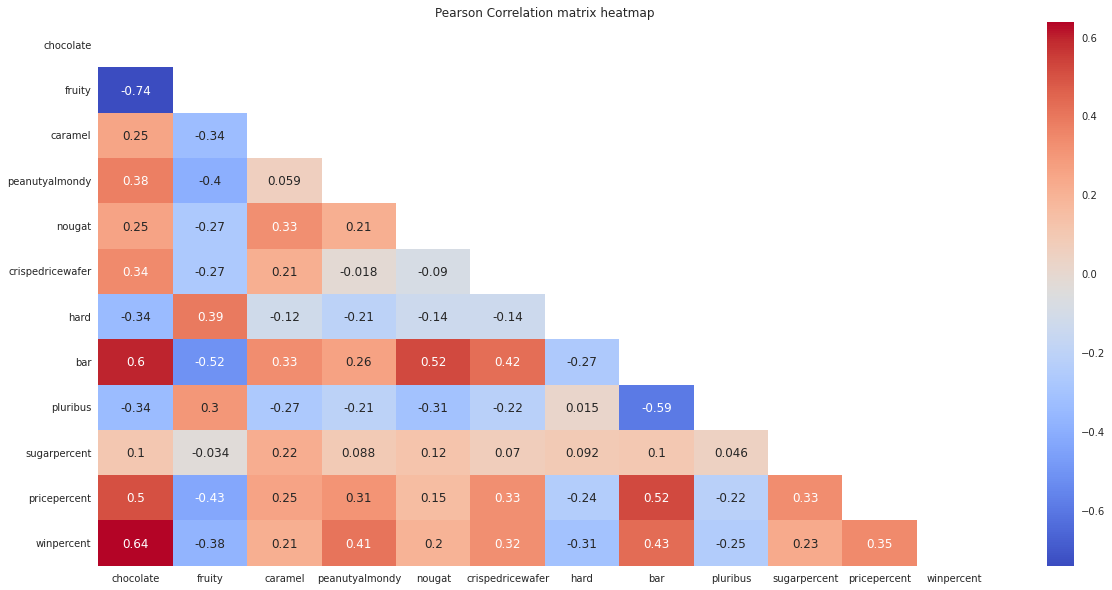

In [8]:
plt.figure(figsize=(20,10))
plt.title('Pearson Correlation matrix heatmap');
mask=np.zeros_like(candy_df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(candy_df.corr(),annot=True, mask=mask, cmap = 'coolwarm')

In [9]:
# Since the matrics is large, here the top ten of correlations (positive and negative):
corr_df = pd.DataFrame([(f1, f2, candy_df.corr()[f1].loc[f2]) for (f1, f2) in itertools.combinations(candy_df.columns[1:].sort_values(), 2)],
             columns=['feature1', 'feature2', 'corr']).sort_values('corr')

corr_df = corr_df.iloc[(-corr_df['corr'].abs()).argsort()].reset_index(drop=True)
corr_df[:10]

,feature1,feature2,corr
0,chocolate,fruity,-0.741721
1,chocolate,winpercent,0.636517
2,bar,chocolate,0.597421
3,bar,pluribus,-0.593409
4,bar,nougat,0.522976
5,bar,pricepercent,0.518407
6,bar,fruity,-0.515066
7,chocolate,pricepercent,0.504675
8,fruity,pricepercent,-0.430969
9,bar,winpercent,0.429929


In [10]:
# Correlation coefficients for winpercent only
corr_df[(corr_df.feature1 == 'winpercent') | (corr_df.feature2 == 'winpercent')]

,feature1,feature2,corr
1,chocolate,winpercent,0.636517
9,bar,winpercent,0.429929
11,peanutyalmondy,winpercent,0.406192
14,fruity,winpercent,-0.380938
16,pricepercent,winpercent,0.345325
25,crispedricewafer,winpercent,0.324680
26,hard,winpercent,-0.310382
38,pluribus,winpercent,-0.247448
40,sugarpercent,winpercent,0.229151
44,caramel,winpercent,0.213416


### Insights from correlation analysis

#### **Taste & Appearcance**
* Having chocolate in the candy would give a high win percentage, followed by being a bar candy and having peanuts/peanut butter/almonds.
* Chocolate frequently comes in bar-shaped candies, also with peanut/almond, crisp texture, and nougat or caramel. The opposite happens with fruit-flavored candies, which frequently miss those categories. Chocolaty candies are rarely fruity.
* Fruity taste is negatively correlated with other tastes (caramel, chocolate and peanutyalmondy), while the rest are positively correlated.
* Fruity candies, as compared to the others, are more likely to be a hard candy.
* There is a very small correlation between caramel and peanutyalmondy, which is surprising because of the popularity of some of the well-known brands due to the combination of these two tastes.
* Packaging in bags is only positively correlated with hard candies. Soft candies are packed mostly in box packages.

#### **Sugar**
* Sugar content is very well balanced among all categories, except price (cheaper candies also have lower sugar levels).
* Sugar is is not that affected by taste and shape factors, which seems to be reasonable. As expected, caramel is naturally mixed with a considerable amount of sugar and therefore has the most impact on sugar amount compared to other categories.
* There is only a slight positive correlation between sugar percentile and the win percentage at 0.23.

#### **Price**
* Chocolate is sold at significantly higher prices than average whereas fruit-flavored at lower prices.
* Price has a slightly more positive correlation with winning than sugar does, but there are some more expensive candies that have a win percentage lower than 40.

**According to the heatmap a first recommendation could be a soft, non fruity, one-bar candy with chocolate, nuts (peanuts, almonds, ..) and some crunch (cookies, waffles, ...).**

### Taste Properties Analysis

### Chocolate

Text(0.5, 0, 'Contains Chocolate ?')

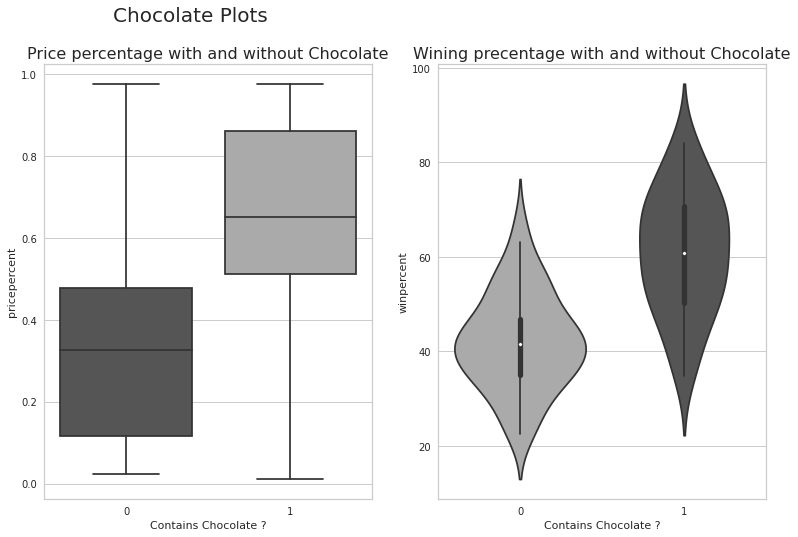

In [11]:
plt.figure(figsize=(20,8))
plt.suptitle("Chocolate Plots", fontsize=20)

plt.subplot(1,3,2)
plt.title("Price percentage with and without Chocolate",fontsize=16)
sns.boxplot(y="pricepercent", x="chocolate", data=candy_df, palette="gray")
plt.xlabel("Contains Chocolate ?")

plt.subplot(1,3,3)
plt.title("Wining precentage with and without Chocolate",fontsize=16)
sns.violinplot(data=candy_df,x="chocolate",y="winpercent",palette="gray_r")
plt.xlabel("Contains Chocolate ?")

Observations

* Chocolate is the key for win (nothing without chocolate has more than 80 as a winning score)
* Chocolate is generally pricey.

### Caramel

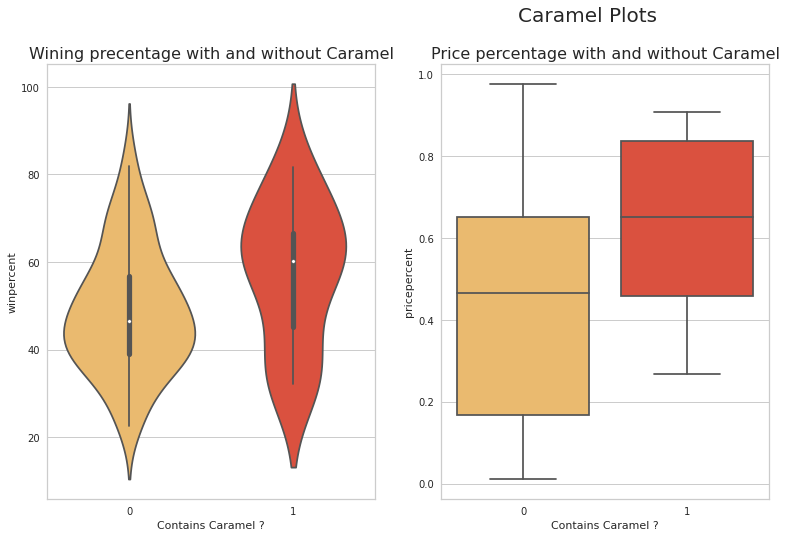

In [12]:
plt.figure(figsize=(20,8))
plt.suptitle("Caramel Plots", fontsize=20)

plt.subplot(1,3,1)
plt.title("Wining precentage with and without Caramel",fontsize=16)
sns.violinplot(data=candy_df,x="caramel",y="winpercent",palette="YlOrRd")
plt.xlabel("Contains Caramel ?")

plt.subplot(1,3,2)
plt.title("Price percentage with and without Caramel",fontsize=16)
sns.boxplot(y="pricepercent", x="caramel", data=candy_df, palette="YlOrRd")
plt.xlabel("Contains Caramel ?")

plt.show()

Observationse

* Caramal does have a slight effect on winning.
* It's not super costly but since it is generally used with multiple ingredients it has higher price.

## Fruity

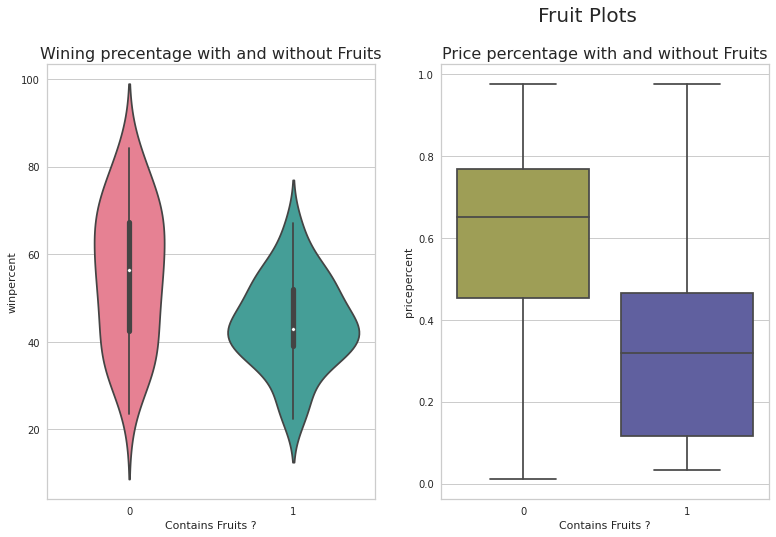

In [13]:
plt.figure(figsize=(20,8))
plt.suptitle("Fruit Plots", fontsize=20)

plt.subplot(1,3,1)
plt.title("Wining precentage with and without Fruits",fontsize=16)
sns.violinplot(data=candy_df,x="fruity",y="winpercent",palette="husl")
plt.xlabel("Contains Fruits ?")

plt.subplot(1,3,2)
plt.title("Price percentage with and without Fruits",fontsize=16)
sns.boxplot(y="pricepercent", x="fruity", data=candy_df, palette="gist_stern_r")
plt.xlabel("Contains Fruits ?")

plt.show()

Observations:

* Fruits are not good for winning. Best score from fruity candy is close to 80, and mean score around 40s.
* fruit-flavored candies are sold at significantly lower prices than average.

## Peanut

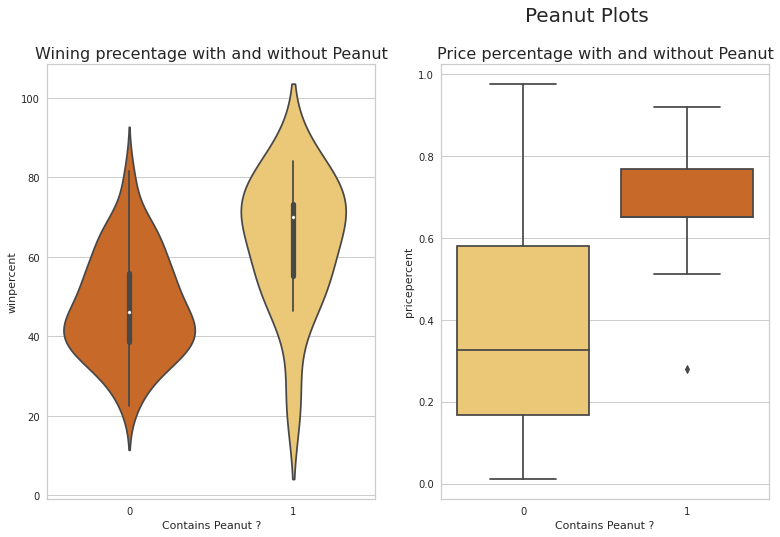

In [14]:
plt.figure(figsize=(20,8))
plt.suptitle("Peanut Plots", fontsize=20)

plt.subplot(1,3,1)
plt.title("Wining precentage with and without Peanut",fontsize=16)
sns.violinplot(data=candy_df,x="peanutyalmondy",y="winpercent",palette="YlOrBr_r")
plt.xlabel("Contains Peanut ?")

plt.subplot(1,3,2)
plt.title("Price percentage with and without Peanut",fontsize=16)
sns.boxplot(y="pricepercent", x="peanutyalmondy", data=candy_df, palette="YlOrBr")
plt.xlabel("Contains Peanut ?")

plt.show()

Observations:

* Peanut is also key of Winning.
* Also expensive.

## Nougat

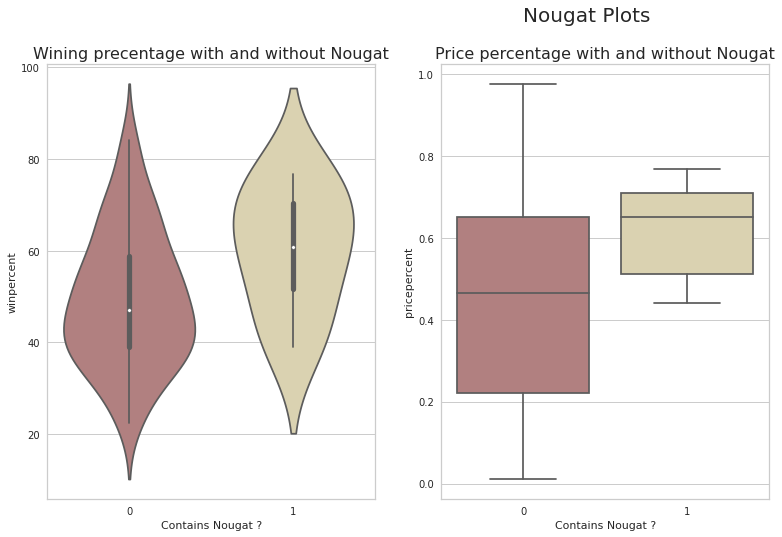

In [15]:
plt.figure(figsize=(20,8))
plt.suptitle("Nougat Plots", fontsize=20)

plt.subplot(1,3,1)
plt.title("Wining precentage with and without Nougat",fontsize=16)
sns.violinplot(data=candy_df,x="nougat",y="winpercent",palette="pink")
plt.xlabel("Contains Nougat ?")

plt.subplot(1,3,2)
plt.title("Price percentage with and without Nougat",fontsize=16)
sns.boxplot(y="pricepercent", x="nougat", data=candy_df, palette="pink")
plt.xlabel("Contains Nougat ?")

plt.show()

Observations:

* It has small effect on winning. general scores are between 60 and 80.
* Slightly more expensive than the others.

## Crisped Rice or Wafer

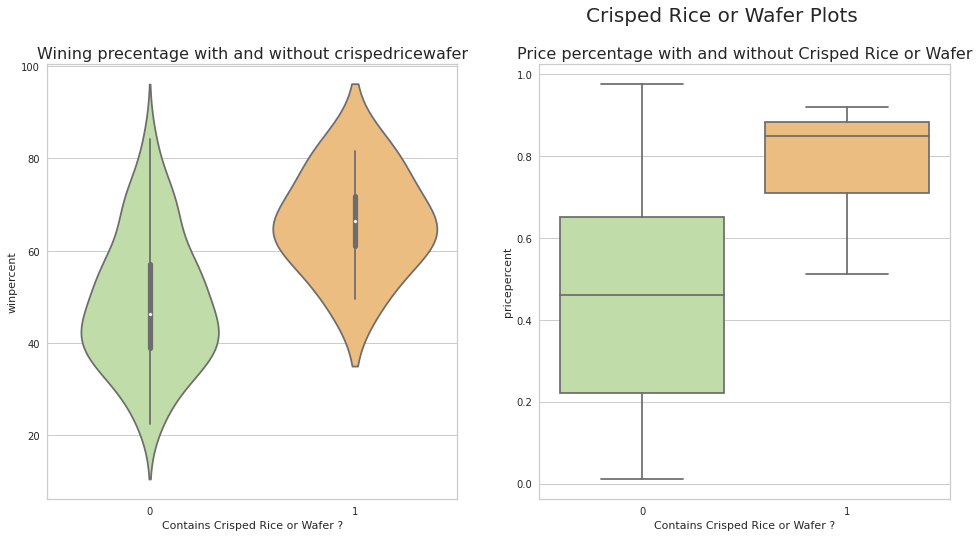

In [16]:
plt.figure(figsize=(25,8))
plt.suptitle("Crisped Rice or Wafer Plots", fontsize=20)

plt.subplot(1,3,1)
plt.title("Wining precentage with and without crispedricewafer",fontsize=16)
sns.violinplot(data=candy_df,x="crispedricewafer",y="winpercent",palette="Spectral_r")
plt.xlabel("Contains Crisped Rice or Wafer ?")

plt.subplot(1,3,2)
plt.title("Price percentage with and without Crisped Rice or Wafer",fontsize=16)
sns.boxplot(y="pricepercent", x="crispedricewafer", data=candy_df, palette="Spectral_r")
plt.xlabel("Contains Crisped Rice or Wafer ?")

plt.show()

Observations:

* It has considerably good effect on winning. Minimun score is 40, which is a good sign
* More expensive than the others.

# 2- Cluster Analysis

We will leverage cluster analysis to understand how many groups we have in our data, what is the average win percent of each cluster, and what is the characteristics of the class with high average win percent.

K-Means is an unsupervised clustering algorithm that groups data into k number of clusters. The number of clusters is user-defined.
Therefore we have to come up with a technique that somehow will help us decide how many clusters we should use for the K-Means model.

The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 12) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

When the distortions are plotted and the plot looks like an arm then the “elbow”(the point of inflection on the curve) is the best value of k.

In our case by applying the Elbow method to the Candy dataset without win percent feature, we are getting the following plot.

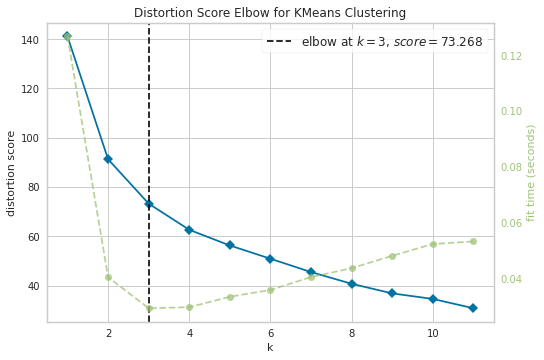

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
candy_df_wo_win = candy_df.drop(['competitorname','winpercent'], axis=1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(candy_df_wo_win)
visualizer.show()

The Elbow method is saying that the optimal number of clusters in the candy data without the win percent column is 3 classes. Therefore in the next step,  apply K-means to our data set with for extracting 3 classes. 

In [18]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(candy_df_wo_win)

In [19]:
# Add a column for cluster label
candy_df['cluster'] = kmeans.labels_
candy_df.groupby(["cluster"])["winpercent"].mean()

cluster
0    43.703954
1    61.295413
2    51.731795
Name: winpercent, dtype: float64

We applied K-means without win percent, now we can map win percent to each class and see the average win percent of each class

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


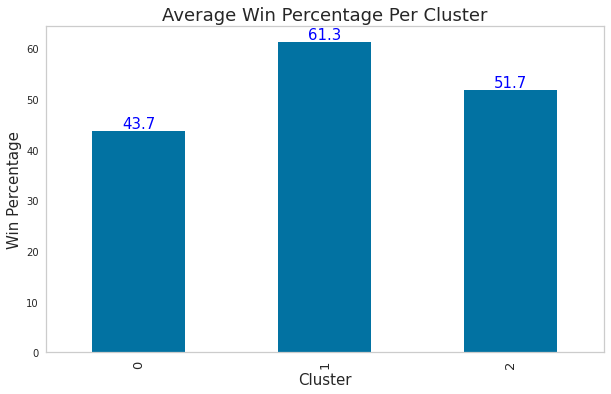

In [20]:
candy_df_clustered = candy_df.groupby(["cluster"])["winpercent"].mean()
fig = candy_df_clustered.plot.bar(figsize=(10,6))
fig.set_title('Average Win Percentage Per Cluster', fontsize=18)
fig.set_xlabel('Cluster', fontsize=15)
fig.set_ylabel('Win Percentage', fontsize=15)
x = [0, 1, 2]    
y = [43.7, 61.3, 51.7]
for i in range (len (x)):
    plt.text(i, y[i], y[i], ha = 'center', va='bottom', fontsize=15, color='blue')
plt.grid(b=None)
plt.xticks(fontsize=13)
plt.show()

As you can see here, entities that are in class 0, have 43.7% as average win percent and the class 1 and 2 has 61.3% and 51.7%, respectively. Therefore if we want to have a new product with a high win percent rate we need to understand the patterns of features in class 1.

Now we can extract all entities that are in class 1 and we can calculate the average value of each feature in this class

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


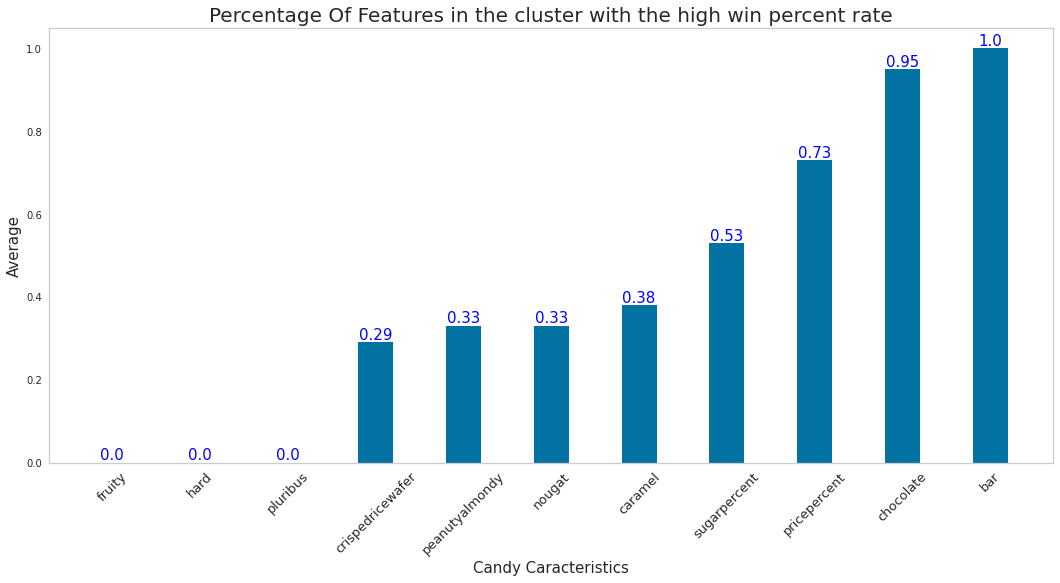

In [21]:
candy_df_class_1 = candy_df[candy_df['cluster'] == 1]
candy_df_class_1 = candy_df_class_1.drop(['competitorname', 'winpercent', 'cluster'], axis=1)
candy_df_class_1.mean().sort_values()
candy_df_class_1 = candy_df_class_1.reindex(candy_df_class_1.mean().sort_values().index, axis=1)
x = candy_df_class_1.columns.tolist()   
y = [round(l, 2) for l in candy_df_class_1.mean().tolist()]
fig = plt.figure(figsize = (18, 8))
plt.bar(x, y, width = 0.4)
plt.title('Percentage Of Features in the cluster with the high win percent rate', fontsize=20)
plt.xlabel('Candy Caracteristics', fontsize=15)
plt.ylabel('Average', fontsize=15)
for i in range (len (x)):
    plt.text(i, y[i], y[i], ha = 'center', va='bottom', fontsize=15, color='blue')
plt.grid(b=None)
plt.xticks(fontsize=13, rotation=45)
plt.show()

From the bar plot, we can see that in class 1 which is the highest win percent class, all of the entities have Bar, 95% has Chocolate, price percent is 73%, and sugar percent is 53%, but entities in this class do not have Pluribus, Hard, and Fruity.
Peanuts, caramel, nougat, etc have a positive effect, so composite candy should have higher rating.
Therefore we can consider this rule:

**USE Chocolate in bar form, containing caramel, nougat, peanuts/almonds, crisped rice/wafer & price 73%, sugar 53% & DO NOT USE Pluribus, Hard, and Fruity**

**main material:**
+ chocolate

**additional:**
+ caramel
+ nougat
+ peanuts and almonds
+ crisped rice/wafer

**form:**
+ bar

# 3- Predictive Analysis

* A predictive analysis is important if we want to have an idea how much the new candy is accepted or not. It is not perfect but it minimizes the risk of going through development, marketing and production of a new candy.
* Clustering gives us patterns of a subset in the data, but we want to see the general behaviors of high win percent products in our dataset. For finding this general pattern, we have to use a regression model.
* As our data is not too big, we will apply Random Forest Regressor from sklearn package in python to predict win percent.
* For the model evaluation, we will use the root mean squared error as metric. 
* We will also leverage the Random Forest Regressor model to look at the feature importance. 

In [22]:
candy_df = candy_df.drop(['cluster'], axis=1)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(candy_df[candy_df.columns[1:-1]],candy_df[candy_df.columns[-1]], test_size=0.3, random_state=42)

In [23]:
# Create a based model
clf_rf = RandomForestRegressor()
# Hyperparameters Tuning
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [6, 7, 8, 9],
    'min_samples_split': [10, 11, 12, 13],
    'n_estimators': [130, 140, 150, 160]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, n_jobs=4, iid=True, refit=True, cv=4, scoring='r2')
# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomForestRegressor(max_depth=10, min_samples_leaf=6, min_samples_split=10,
                      n_estimators=160)

In [24]:
clf_rf_best = grid_search.best_estimator_
# Perform prediction on the test set & calculate the mean squared error
rmse_err = math.sqrt(mean_squared_error(y_test,clf_rf_best.predict(X_test)))
rmse_err

11.548350957214547

In [25]:
# Determine feature importance values
importances = clf_rf_best.feature_importances_
# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


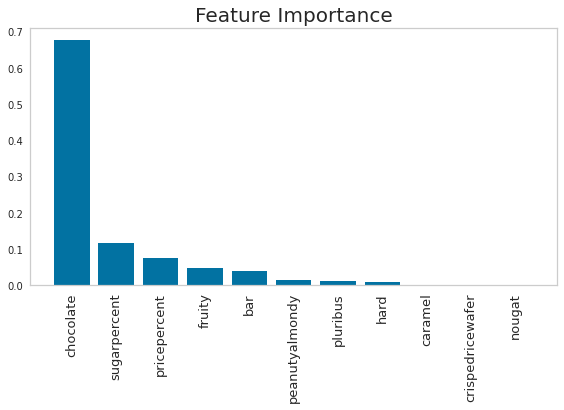

In [26]:
# Visualize the feature importance 
plt.title('Feature Importance', fontsize=20)
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.grid(b=None)
plt.xticks(fontsize=13)
plt.show()

Overall for predicting the win percent of a new product, Chocolate, Sugar, bar, and Price are the most important features.

## 4 - Summary & Recommendations

### We want to create a brand new candy

* We decided to use a data-driven approach.
* We collected data on products in the market and their characteristics and customer sentiment.

### Through the analysis, our goal is 
* To understand the rules, patterns, or relations of features with win percent. If we understand these then we can map it to the new product.
* To find out which product characteristics drive customer sentiment and subsequently make a recommendation on a new product.
* To implement a Machine Learning pipeline to predict the win Percentage of a new candy.

### WE CAME UP WITH THE FOLLOWING RECOMMENDATIONS & CONCLUSIONS
* Our recommendation is a soft, non-fruity, one-bar candy with chocolate, nougat, caramel, nuts (peanuts, almonds, ..), and some crunch (cookies, waffles, ...). 
* We need to investigate the shopping patterns of customers (Are they health conscious? Do they buy what they like, or buy cheaper options?)
* In the end, we need to combine the findings of this study with our investigations to design candy which people will like and will buy.